
### Keterangan [data](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) yang digunakan

- 1 — age (numeric)
- 2 — job : type of job (categorical: ‘admin.’,’blue-collar’,’entrepreneur’,’housemaid’,’management’,’retired’,’self-employed’,’services’,’student’,’technician’,’unemployed’,’unknown’)
- 3 — marital : marital status (categorical: ‘divorced’, ‘married’, ‘single’, ‘unknown’; note: ‘divorced’ means divorced or widowed)
- 4 — education (categorical: ‘basic.4y’,’basic.6y’,’basic.9y’,’high.school’,’illiterate’,’professional.course’,’university.degree’,’unknown’)
- 5 — default: has credit in default? (categorical: ‘no’, ‘yes’, ‘unknown’)
- 6 — housing: has housing loan? (categorical: ‘no’, ‘yes’ ,’unknown’)
- 7 — loan: has personal loan? (categorical: ‘no’, ‘yes’, ‘unknown’)

#### related with the last contact of the current campaign:
- 8 — contact: contact communication type (categorical: ‘cellular’, ‘telephone’)
- 9 — month: last contact month of year (categorical: ‘jan’, ‘feb’, ‘mar’, …, ‘nov’, ‘dec’)
- 10 — day_of_week: last contact day of the week (categorical: ‘mon’,’tue’,’wed’,’thu’,’fri’)
- 11 — duration: last contact duration, in seconds (numeric).
Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
- 12 — campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- 13 — pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 14 — previous: number of contacts performed before this campaign and for this client (numeric)
- 15 — poutcome: outcome of the previous marketing campaign (categorical: ‘failure’,’nonexistent’,’success’)

#### social and economic context attributes
- 16 — emp.var.rate: employment variation rate — quarterly indicator (numeric)
- 17 — cons.price.idx: consumer price index — monthly indicator (numeric)
- 18 — cons.conf.idx: consumer confidence index — monthly indicator (numeric)
- 19 — euribor3m: euribor 3 month rate — daily indicator (numeric)
- 20 — nr.employed: number of employees — quarterly indicator (numeric)

#### Output variable (desired target):
21 — y — has the client subscribed a term deposit? (binary: ‘yes’, ‘no’)  

### Import module 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

### Membuat fungsi evaluation model 

In [2]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Prediction Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Calculate precision, recall, f1-score, and kappa score
    precision = metrics.precision_score(y_test, y_pred)

    # Caclculate recall 
    recall = metrics.recall_score(y_test, y_pred)
    # calculate f1-score
    f1_score = metrics.f1_score(y_test, y_pred)
    # calculate kappa score 
    kappa_score = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'kappa_score': kappa_score, 
           'fpr': fpr, 'tpr': tpr, 'auc_score': auc_score, 'cm': cm}
    # return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'kappa_score': kappa_score, 
    #         'cm': cm}        

### Melakukan load data

In [3]:
def get_data(url): 
    df_bank = pd.read_csv(url,sep=';',engine='python')
    return df_bank 

### Melakukan processing data

In [4]:
def processing_eda(df):
    df = df.rename(columns={'y': 'deposit'}) 
    df = scalling_data(df)
    df = encoding_data(df)
    return df 

In [5]:
def scalling_data(df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

In [6]:
kol_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
def encoding_data(df):
    # Encoder 
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(sparse=False)

    # process encode categorical data 
    df_encode = pd.DataFrame(encoder.fit_transform(df[kol_cat]))
    ##print(df_encode)
    df_encode.columns = encoder.get_feature_names(kol_cat)
    #print(df_encode.columns)
    
    df = df.drop(kol_cat ,axis=1)

    #print(df)
    df = pd.concat([df_encode, df], axis=1)
    # Encode target value
    df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
    return df

In [7]:
def split_data(df,test_size):
    # Select Target
    target = df['deposit']
    # Select Features
    feature = df.drop('deposit', axis=1)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=test_size, 
                                                    random_state=1)

    return X_train,X_test,y_train,y_test 

In [8]:
url = "https://raw.githubusercontent.com/rifaidimas/H8_1/main/data/bank.csv"
df = get_data(url)
df = processing_eda(df) 
X_train, X_test, y_train, y_test = split_data(df,0.2) 

### Membangun model Decision Tree

In [9]:
from sklearn import tree
model_dtree = tree.DecisionTreeClassifier(random_state=0)
model_dtree.fit(X_train, y_train)
eval_dtree = evaluate_model(model_dtree, X_test, y_test)
print('DTree Accuracy:', eval_dtree['accuracy'])

DTree Accuracy: 0.8820081831250691


### Membangun model Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=0)
model_rf.fit(X_train, y_train)
eval_rf = evaluate_model(model_rf, X_test, y_test)
print('RandomForest Accuracy:', eval_rf['accuracy'])

RandomForest Accuracy: 0.907110472188433


### Membangun model Naive Bayes 

In [11]:
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
eval_nb = evaluate_model(model_nb, X_test, y_test)
print('Naive Bayes Accuracy:', eval_nb['accuracy'])

Naive Bayes Accuracy: 0.8514873382726971


### Membangun model KNN model 

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
eval_knn = evaluate_model(model_knn, X_test, y_test)
print('KNN Accuracy:', eval_knn['accuracy'])

KNN Accuracy: 0.8894172287957536


### Membangun model SVM 

In [13]:
from sklearn import svm
model_svm= svm.SVC(probability=True)
model_svm.fit(X_train,y_train)
eval_svm = evaluate_model(model_svm, X_test, y_test)
print('SVM Accuracy:', eval_svm['accuracy'])

SVM Accuracy: 0.8893066460245493


### Perbandingan dari model

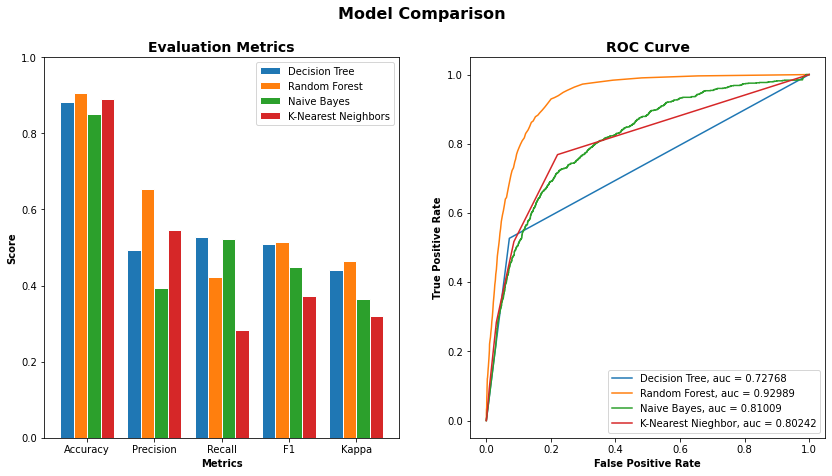

In [14]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [eval_dtree['accuracy'], eval_dtree['precision'], eval_dtree['recall'], eval_dtree['f1_score'], eval_dtree['kappa_score']]
rf_score = [eval_rf['accuracy'], eval_rf['precision'], eval_rf['recall'], eval_rf['f1_score'], eval_rf['kappa_score']]
nb_score = [eval_nb['accuracy'], eval_nb['precision'], eval_nb['recall'], eval_nb['f1_score'], eval_nb['kappa_score']]
knn_score = [eval_knn['accuracy'], eval_knn['precision'], eval_knn['recall'], eval_knn['f1_score'], eval_knn['kappa_score']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(eval_dtree['fpr'], eval_dtree['tpr'], label='Decision Tree, auc = {:0.5f}'.format(eval_dtree['auc_score']))
ax2.plot(eval_rf['fpr'], eval_rf['tpr'], label='Random Forest, auc = {:0.5f}'.format(eval_rf['auc_score']))
ax2.plot(eval_nb['fpr'], eval_nb['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(eval_nb['auc_score']))
ax2.plot(eval_knn['fpr'], eval_knn['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(eval_knn['auc_score']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()